各種ライブラリが必要となるため、プログラム実行時はインストールすること

py -m pip install <ライブラリ>

In [1]:
# 事前準備
import numpy as np
import scipy as sp
import pandas as pd
from pandas import Series, DataFrame

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
plt.style.use("ggplot")
%matplotlib inline

# 少数第3位まで表示
%precision 3

# グラフの日本語表記対応
import japanize_matplotlib

# 第７章 ディープラーニングの研究分野

## 7-1 画像認識

### 7-1-1 画像認識における畳み込みニューラルネットワークの例

画像認識分野においても、ニューラルネットワークの設計が重要となる。本タスクでは畳み込みニューラルネットワーク(CNN)が良く利用されており、以降に様々な手法を示す。

|手法|年代|開発者|説明|
|---|---|---|---|
|LeNet|1998年|Yann LeCun|畳み込み層とプーリング層を交互に重ねたネットワーク|
|AlexNet|2012年|トロント大学：Hinton|ILSVRC(※)においてディープラーニングに基づくモデルとして優勝<br>ReLUやドロップアウトを用いている点が特徴<br>ディープラーニングの火付け役|
|GoogLeNet|2014年|Google|AlexNetより深い22層となる構造を実現し、パラメータ数の削減に成功|
|VGGNet|2014年|オックスフォード大学|AlexNetより深い16層および19層のネットワーク構造（ILSVRCで準優勝）|
|ResNet|2015年|当時MS：Kaiming He|層を深くすると性能が落ちる問題を解決|
|MobileNets|2017年|Google|リソースに制約のある組み込み機器などで速度を考慮し、<br>効率的に精度を上げることを可能にしたモデル|

※画像の位置特定(Object localization)と物体検出(Object detection)の制度を競う画像認識コンテスト

#### 7-1-1-1 文字認識(手書き数字の判定)

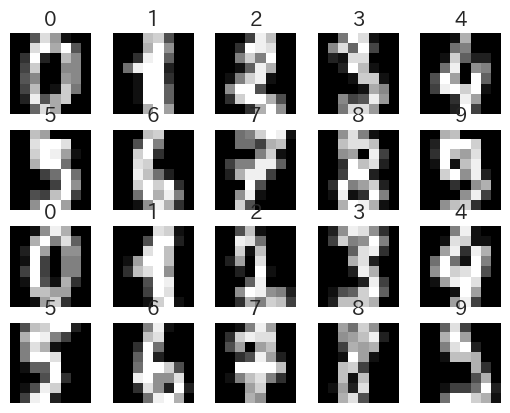

In [2]:
#################################
# 文字認識                      #
#################################

# 手書きデータ
from sklearn import datasets
digits = datasets.load_digits()

# 画像確認
for i in range(20):
  plt.subplot(4, 5, i+1)
  plt.axis("off")
  plt.title(str(digits.target[i]))
  plt.imshow(digits.images[i], cmap="gray")

plt.show()

In [6]:
########################################
# 機械学習                             #
########################################

from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics
from sklearn.metrics import accuracy_score

# データ読み込み
digits = datasets.load_digits()
x = digits.images
y = digits.target

# 2次元配列を1次元配列に変換
x = x.reshape((-1, 64))

# 学習データとテストデータに分割
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 学習
clf = svm.LinearSVC(dual='auto')
clf.fit(x_train, y_train)

# 予測
y_pred = clf.predict(x_test)
print(f'予測:{accuracy_score(y_test, y_pred)}')

予測:0.9333333333333333


In [7]:
# 学習済みモデルの保存
import joblib
joblib.dump(clf, 'digits.pkl')

['digits.pkl']

上記で学習した結果を用いて、手書き画像を判定する。

In [ ]:
###########################################
# 画像判定                                #
###########################################

import cv2
import joblib

def predict_digit(filename):
  # 学習済みモデルの読み込み
  clf = joblib.load("digits.pkl")
  # 手書きデータファイルの読み込み
  my_img = cv2.imread(filename)
  # 画像データを学習データに合わせる
  my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
  my_img = cv2.resize(my_img, (8,8))
  my_img = 15 - my_img
  # 2次元データを1次元データに変換
  my_img = my_img.reshape((-1, 64))
  # データを予測する
  res = clf.predict(my_img)

  return res[0]

# 画像ファイルを指定
# predict_digitメソッドに対して、画像を指定する

#### 7-1-1-2 文字認識(DLで手書き数字の判定)

MNISTデータ(白黒画像の手書き数字のデータセット)を利用する。

画像を確認する。

11490434/11490434 [==============================] - 4s 0us/step


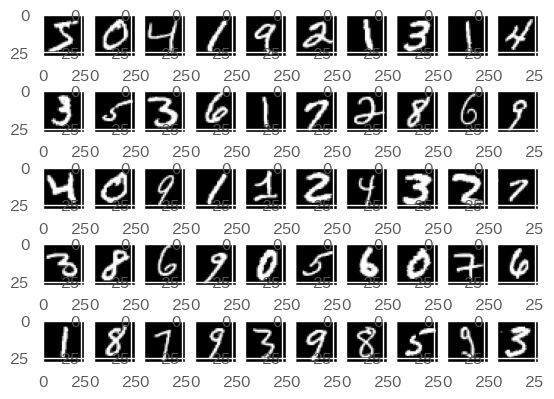

In [9]:
import keras
from keras.datasets import mnist

# MNISTデータの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像確認
for i in range(0, 50):
  plt.subplot(5, 10, i + 1)
  plt.imshow(X_train[i], cmap='gray')

plt.show()

最低限のニューラルネットワークを利用し、MNISTの手書き数字を分類する。

1. 一次元配列に変換し正規化
1. モデル構築

In [10]:
# 一次元配列に変換（28×28ピクセル=784）
# 正規化として、0.0～1.0のため、色の最大値255で割る
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# データの確認
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'), 10)

In [12]:
###############################################
# Kerasでのモデル構築（手書き数字分類）       #
###############################################

# 入出力
# in：1枚の画像データ、out：0～9の10個の判定
in_size = 28 * 28
out_size = 10

# モデル構造の定義
Dense = keras.layers.Dense
model = keras.models.Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dense(out_size, activation='softmax'))

# モデルを構築
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# 学習
model.fit(X_train, y_train, batch_size=20, epochs=20)

# 評価
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

Epoch 1/20
3000/3000 [==============================] - 49s 15ms/step - loss: 0.1892 - accuracy: 0.9437
Epoch 2/20
3000/3000 [==============================] - 59s 20ms/step - loss: 0.0782 - accuracy: 0.9760
Epoch 3/20
3000/3000 [==============================] - 153s 51ms/step - loss: 0.0532 - accuracy: 0.9828
Epoch 4/20
3000/3000 [==============================] - 93s 31ms/step - loss: 0.0378 - accuracy: 0.9878
Epoch 5/20
3000/3000 [==============================] - 71s 24ms/step - loss: 0.0287 - accuracy: 0.9908
Epoch 6/20
3000/3000 [==============================] - 70s 23ms/step - loss: 0.0227 - accuracy: 0.9924
Epoch 7/20
3000/3000 [==============================] - 69s 23ms/step - loss: 0.0187 - accuracy: 0.9939
Epoch 8/20
3000/3000 [==============================] - 56s 19ms/step - loss: 0.0162 - accuracy: 0.9948
Epoch 9/20
3000/3000 [==============================] - 51s 17ms/step - loss: 0.0141 - accuracy: 0.9952
Epoch 10/20
3000/3000 [==============================] - 46s 15

#### 7-1-1-3 文字認識(MLPの利用)

MLPとは、多層パーセプトロン（Multilayer perceptron）のアルゴリズムである。

MLPの特徴をプログラムに反映する。

In [13]:
######################################
# MLPでMNISTの分類問題に挑戦         #
######################################

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import rmsprop
from keras.datasets import mnist

# MNISTデータの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 一次元配列に変換（28×28ピクセル=784）
# 正規化として、0.0～1.0のため、色の最大値255で割る
X_train = X_train.reshape(-1, 784).astype('float32') / 255
X_test = X_test.reshape(-1, 784).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'), 10)

# 入出力
# in：1枚の画像データ、out：0～9の10個の判定
in_size = 28 * 28
out_size = 10

# モデル構造の定義
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(out_size, activation='softmax'))

# モデルを構築
model.compile(
    loss='categorical_crossentropy',
    optimizer=rmsprop.RMSprop(),
    metrics=['accuracy'])

# 学習
hist = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=50,
                 verbose=1,
                 validation_data=(X_test, y_test))

# 評価
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

Epoch 1/50
469/469 [==============================] - 16s 32ms/step - loss: 0.2559 - accuracy: 0.9212 - val_loss: 0.1262 - val_accuracy: 0.9599
Epoch 2/50
469/469 [==============================] - 18s 39ms/step - loss: 0.1031 - accuracy: 0.9679 - val_loss: 0.0759 - val_accuracy: 0.9763
Epoch 3/50
469/469 [==============================] - 22s 47ms/step - loss: 0.0724 - accuracy: 0.9773 - val_loss: 0.0743 - val_accuracy: 0.9781
Epoch 4/50
469/469 [==============================] - 23s 49ms/step - loss: 0.0583 - accuracy: 0.9817 - val_loss: 0.0732 - val_accuracy: 0.9785
Epoch 5/50
469/469 [==============================] - 20s 42ms/step - loss: 0.0463 - accuracy: 0.9853 - val_loss: 0.0671 - val_accuracy: 0.9818
Epoch 6/50
469/469 [==============================] - 40s 85ms/step - loss: 0.0401 - accuracy: 0.9874 - val_loss: 0.0826 - val_accuracy: 0.9760
Epoch 7/50
469/469 [==============================] - 44s 94ms/step - loss: 0.0338 - accuracy: 0.9891 - val_loss: 0.0681 - val_accuracy:

実行した結果、約98.4%(0.9843)であり、「7-1-1-2」の結果より若干改善されていることがわかる。ちなみに、lossとは、正解とどれくらい離れているかを表す数値である。

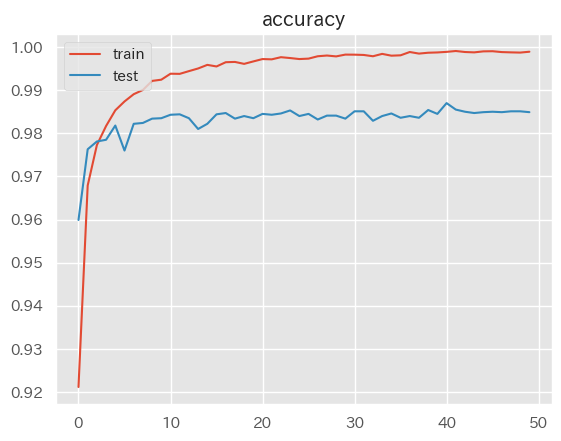

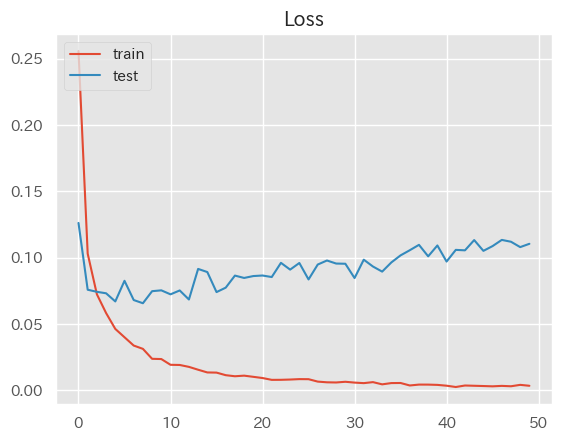

In [14]:
#################################
# 学習の様子を描画              #
#################################

# 正解率の推移
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 7-1-1-4 文字認識(CNNの利用)

CNN(Conbolutional Neural Network)を利用することで、より高い精度を出すことが可能である。

1. 入力値
1. 畳み込み層：Conv2D
1. プーリング層：MaxPooling2D
1. 全結合層
1. 出力層

In [16]:
######################################
# CNNでMNISTの分類問題に挑戦         #
######################################

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import rmsprop
from keras.datasets import mnist

# 入出力
# in：1枚の画像データ、out：0～9の10個の判定
in_rows = 28
in_cols = 28
in_color = 1
in_shape = (in_rows, in_cols, in_color)
out_size = 10

# MNISTデータの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 3次元配列に変換
# 正規化として、0.0～1.0のため、色の最大値255で割る
X_train = X_train.reshape(-1, in_rows, in_cols, in_color).astype('float32') / 255
X_test = X_test.reshape(-1, in_rows, in_cols, in_color).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'), 10)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'), 10)

# モデル構造の定義
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(out_size, activation='softmax'))

# モデルを構築
model.compile(
    loss='categorical_crossentropy',
    optimizer=rmsprop.RMSprop(),
    metrics=['accuracy'])

# 学習
hist = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=12,
                 verbose=1,
                 validation_data=(X_test, y_test))

# 評価
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

Epoch 1/12
469/469 [==============================] - 275s 576ms/step - loss: 0.2507 - accuracy: 0.9220 - val_loss: 0.0591 - val_accuracy: 0.9811
Epoch 2/12
469/469 [==============================] - 315s 671ms/step - loss: 0.0867 - accuracy: 0.9743 - val_loss: 0.0385 - val_accuracy: 0.9858
Epoch 3/12
469/469 [==============================] - 257s 547ms/step - loss: 0.0620 - accuracy: 0.9811 - val_loss: 0.0367 - val_accuracy: 0.9871
Epoch 4/12
469/469 [==============================] - 236s 503ms/step - loss: 0.0515 - accuracy: 0.9846 - val_loss: 0.0353 - val_accuracy: 0.9892
Epoch 5/12
469/469 [==============================] - 221s 471ms/step - loss: 0.0445 - accuracy: 0.9869 - val_loss: 0.0284 - val_accuracy: 0.9906
Epoch 6/12
469/469 [==============================] - 288s 613ms/step - loss: 0.0398 - accuracy: 0.9881 - val_loss: 0.0325 - val_accuracy: 0.9897
Epoch 7/12
469/469 [==============================] - 1164s 2s/step - loss: 0.0383 - accuracy: 0.9885 - val_loss: 0.0288 - v

実行結果として、99%(0.9902)となり、MLPよりも高精度になったことが確認できる。

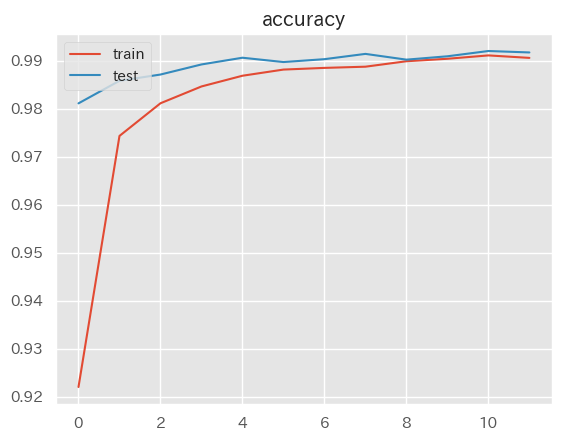

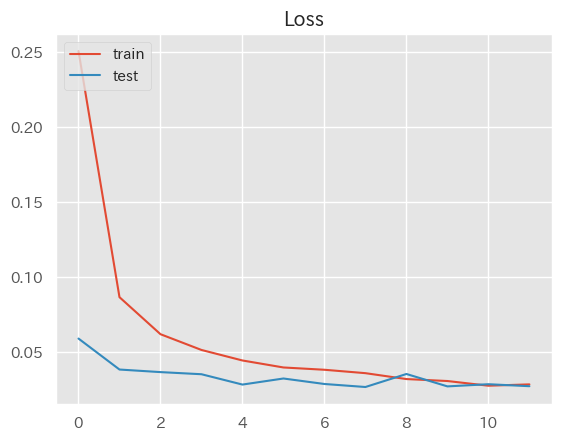

In [17]:
#################################
# 学習の様子を描画              #
#################################

# 正解率の推移
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 7-1-2 物体検出

物体検出とは画像内の物体の位置とカテゴリ(クラス)の検出のことである。画像内から**バウンディングボックス**(Bounding box)と呼ばれる矩形領域で位置とカテゴリを特定する。

従来、ディープラーニング以外の手法で物体検出し、そのあとでカテゴリ識別する流れであったが、ディープラーニングを物体検出に利用することで学習時間の短縮と検出精度の向上を実現している。

|手法|年代|説明|
|---|---|--|
|R-CNN|2014年|CNNのアルゴリズムを物体検出に応用<br>人間が行う物体認識のように領域(Region)ごとに特徴量を抽出|
|Faster R-CNN|2015年|事項時間がかかる問題を物体領域候補の抽出にDNNを用いて高速化<br>End-to-End(画像入力から物体検出まで)で学習可能な一気通貫学習が可能|
|YOLO(You Only Look Once)|2016年|R-CNNの改良版<br>画像をグリッドに分割し、領域ごと|
|SSD(Single Shot MultiBox Detector)|-|フィルタサイズを小さくし高速を図ったアルゴリズム|

#### 7-1-2-1 MLPの利用

CIFAR-10のデータセットを利用する。

In [18]:
######################################
# MLPでCIFAR-10の分類問題に挑戦      #
######################################

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import rmsprop
from keras.datasets import cifar10

# データ初期値
num_classes = 10
in_rows = 32
in_cols = 32
in_size = in_rows * in_cols * 3

# CIFAR10データの読み込み
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 一次元配列に変換
# 正規化として、0.0～1.0のため、色の最大値255で割る
X_train = X_train.reshape(-1, in_size).astype('float32') / 255
X_test = X_test.reshape(-1, in_size).astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'), num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'), num_classes)

# モデル構造の定義
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dense(num_classes, activation='softmax'))

# モデルを構築
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# 学習
hist = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=50,
                 verbose=1,
                 validation_data=(X_test, y_test))

# 評価
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

170498071/170498071 [==============================] - 95s 1us/step
Epoch 1/50
1563/1563 [==============================] - 105s 60ms/step - loss: 1.8954 - accuracy: 0.3271 - val_loss: 1.7309 - val_accuracy: 0.3831
Epoch 2/50
1563/1563 [==============================] - 165s 106ms/step - loss: 1.7064 - accuracy: 0.3899 - val_loss: 1.6365 - val_accuracy: 0.4151
Epoch 3/50
1563/1563 [==============================] - 153s 98ms/step - loss: 1.6331 - accuracy: 0.4198 - val_loss: 1.6591 - val_accuracy: 0.3957
Epoch 4/50
1563/1563 [==============================] - 171s 109ms/step - loss: 1.5947 - accuracy: 0.4297 - val_loss: 1.5865 - val_accuracy: 0.4323
Epoch 5/50
1563/1563 [==============================] - 175s 112ms/step - loss: 1.5657 - accuracy: 0.4427 - val_loss: 1.5498 - val_accuracy: 0.4478
Epoch 6/50
1563/1563 [==============================] - 159s 102ms/step - loss: 1.5433 - accuracy: 0.4520 - val_loss: 1.5908 - val_accuracy: 0.4382
Epoch 7/50
1563/1563 [========================

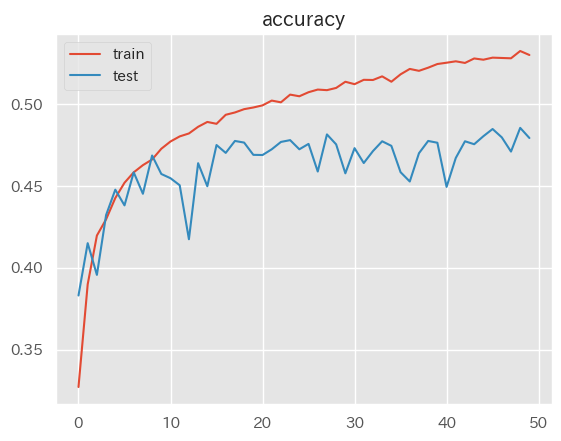

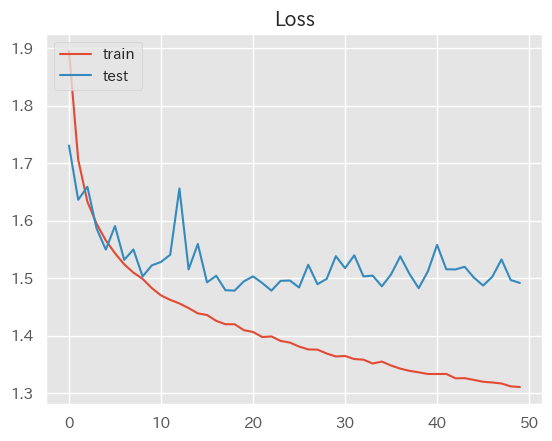

In [19]:
#################################
# 学習の様子を描画              #
#################################

# 正解率の推移
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 7-1-2-2 CNNの利用

MLPを使った分類では、正解率：48%であり、2回に1回は期待と異なる結果であった。

CNNを使った分類ではどうなるかを検証する。

In [20]:
######################################
# CNNでCIFAR-10の分類問題に挑戦      #
######################################

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10

# データ初期値
num_classes = 10
in_rows = 32
in_cols = 32
in_shape = (in_rows, in_cols, 3)

# CIFAR10データの読み込み
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 一次元配列に変換
# 正規化として、0.0～1.0のため、色の最大値255で割る
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# ラベルデータをOne-hotベクトルに変換
y_train = keras.utils.np_utils.to_categorical(y_train.astype('int32'), num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test.astype('int32'), num_classes)

# モデル構造の定義
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=in_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# モデルを構築
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# 学習
hist = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=15,
                 verbose=1,
                 validation_data=(X_test, y_test))

# 評価
score = model.evaluate(X_test, y_test, verbose=1)
print('正解率=', score[1], 'loss=', score[0])

Epoch 1/15
1563/1563 [==============================] - 607s 386ms/step - loss: 1.5215 - accuracy: 0.4442 - val_loss: 1.1506 - val_accuracy: 0.5842
Epoch 2/15
1563/1563 [==============================] - 624s 399ms/step - loss: 1.1372 - accuracy: 0.5955 - val_loss: 0.9745 - val_accuracy: 0.6575
Epoch 3/15
1563/1563 [==============================] - 555s 355ms/step - loss: 1.0030 - accuracy: 0.6452 - val_loss: 0.8646 - val_accuracy: 0.6979
Epoch 4/15
1563/1563 [==============================] - 572s 366ms/step - loss: 0.9136 - accuracy: 0.6753 - val_loss: 0.8457 - val_accuracy: 0.7093
Epoch 5/15
1563/1563 [==============================] - 630s 403ms/step - loss: 0.8526 - accuracy: 0.7005 - val_loss: 0.7899 - val_accuracy: 0.7303
Epoch 6/15
1563/1563 [==============================] - 597s 382ms/step - loss: 0.8049 - accuracy: 0.7172 - val_loss: 0.7660 - val_accuracy: 0.7306
Epoch 7/15
1563/1563 [==============================] - 596s 381ms/step - loss: 0.7656 - accuracy: 0.7312 - val_

上記の結果、学習に時間がかかったが、かなりの改善がみられた。

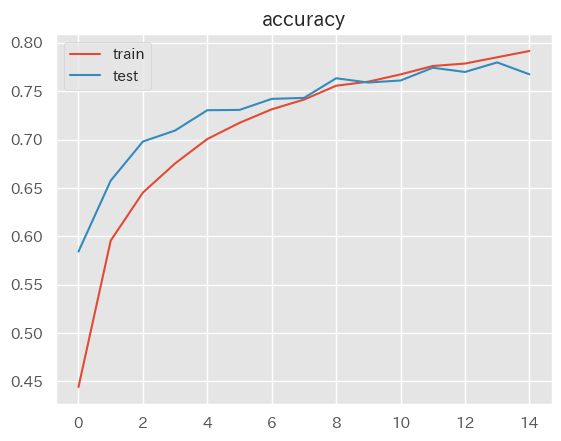

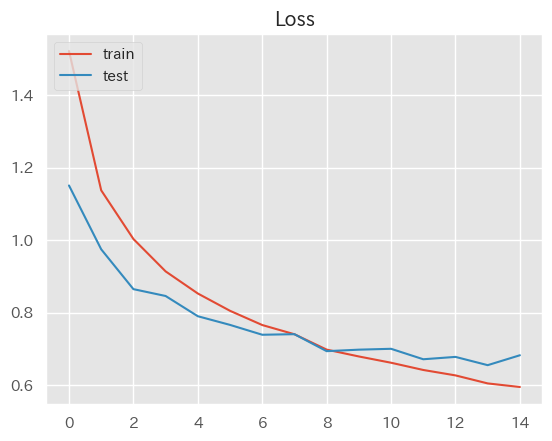

In [21]:
#################################
# 学習の様子を描画              #
#################################

# 正解率の推移
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ロスの推移
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 7-1-3 物体セグメンテーション

物体セグメンテーションは、物体検出のように矩形のBounding Boxを用いず、対象物体と背景を境界まで詳細に切り分けて識別する。

|手法|説明|
|---|---|
|セマンティック・セグメンテーション|同じカテゴリに属する複数の物体が同一ラベルとして扱う<br>FCN(Fully Convolutional Networks)という手法がある|
|インスタンス・セグメンテーション|個々の物体ごとに認識し切り分ける|

### 7-1-4 画像キャプション生成

画像処理と自然言語処理の融合の研究として、画像を入力すると、その説明文(キャプション)を自動的に生成する画像キャプション生成がある。CNNとLSTMの技術を用いる。

### 7-1-5 画像生成

Google Brainのイアン・J・グッドフェローが提案した**敵対的生成ネットワーク**(Generative adverarial networks:GAN)が特に利用される。

敵対的生成ネットワークは、2つのニューラルネットワークを競わせてデータを学習させる。

![GAN概要](./img/GAN概要.png)

### 7-1-6 画像認識ライブラリ

|ライブラリ|説明|
|---|---|
|TensorFlow|多次元のデータ構造を流れるように処理することができる深層学習（ディープラーニング）を行えるライブラリ|
|Keras|TensorFlowやTheano上で動くニューラルネットワークライブラリ|
|Caffe|「画像認識」に特化しており、高速処理が可能であるライブラリ|
|Chainer||
|PyTorch||
|OpenCV|前処理として以下が可能<br>・カラー画像を色味のないモノクロ画像に変換する**グレースケール化**<br>・画像をぼかすことでノイズ除去を行う**平滑化**<br>・画像の明るさやコントラストを調整する**ヒストグラム平坦化**|

### 7-1-7 各種サービス

現状、様々なサービスが提供されており、３大クラウドサービスを展開する企業からもAPIとして提供される。

このAPIを下表にまとめる

|企業|API|説明|
|---|---|---|
|Microsoft|Computer Vision|画像や動画を分析し、説明、タグ、オブジェクト、テキストを抽出|
|Microsoft|Custom Vision|独自の画像を使用してカスタム画像分類と物体検出モデルをトレーニングするために使用|
|Microsoft|Face|顔検出および顔認識ソリューションをビルド|
|Microsoft|Form Recognizer|スキャンしたフォームや請求書から情報を抽出|
|Amazon|||
|Google|||

## 7-2 自然言語処理

自然言語処理(NLP:Natural Language Processing)は、人間が日常的に使用する言語をコンピュータに処理させる技術である。

1. 形態素解析
1. 構文解析
1. 意味解析
1. 文脈解析

### 7-2-1 形態素解析

形態素解析(Morphological Analysis)は、自然言語について意味を持つ表現要素の最小単位である形態素(単語、品詞)まで分割し解析する手法である。

形態素解析で分割した単語を活用するためには、**データクレンジング**によって表記ゆれの統一や不要な文字の削除を行い、**BOW**(bag-of-words)などの手法でデータをベクトル化する必要がある。分割した単語の重要度を評価する場合は、**TF-IDF**などを用いる。

#### 7-2-1-1 形態素解析の実装(前提モジュールインストール)

##### モジュール準備

Windows環境の場合、以下のサイトにアクセスしてダウンロード（mecab-64-0.996.2.exe）しインストールする。

https://github.com/ikegami-yukino/mecab/releases

Linuxの場合（Google Colaboratory）、以下のコマンドを実行し、環境にインストールする。

In [ ]:
!apt-get install mecab libmecab-dev mecab-ipadic-utf8
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y

##### インストール

以下のコマンドを実行し、python環境にインストールする。

pip install mecab-python3==0.996.3

pip install unidic-lite

### 7-2-X 各種サービス

現状、様々なサービスが提供されており、３大クラウドサービスを展開する企業からもAPIとして提供される。

このAPIを下表にまとめる

|企業|API|説明|
|---|---|---|
|Microsoft|Language|テキストの理解と分析、音声またはテキストベースのコマンドを理解できる言語モデルのトレーニング、インテリジェントなアプリケーションの構築を行う機能にアクセス|
|Microsoft|Translator|60 以上の言語間でテキストを翻訳|
|Microsoft|Speech|音声の認識および合成と、音声言語の翻訳|
|Microsoft|Azure Bot|対話型 AI のプラットフォームが提供|
|Amazon|||
|Google|||

## 7-3 音声処理

### 7-3-1 音声認識

音声認識の研究は以下の流れで進化している。

|年代|仕組み|
|---|---|
|～2010年まで|隠れマルコフモデル(Hidden Markov Model)である**GMM-HMM**やn-gramなどの統計的モデルが一般的|
|2010年代|ディープニューラルネットワークの利用で、**DNN-HMM**が一般的|
|近年|HMMを用いずRNNの一種であるLSTMを用いた**CTC**(Connectionist Temporal Classification)に注目|

音声認識アシスタントとしては以下がある。

|企業|AIアシスタント|
|---|---|
|Apple|Siri|
|Amazon|Alexa|
|Microsoft|Cortana|

### 7-3-2 音声合成

音声認識は人間の音声をコンピュータなどに認識させることであるが、音声合成は、人間の音声を人工的に作成することである。この領域でもディープラーニングの活用が可能である。

特に**WaveNet**というアルゴリズムが注目されている。スマートスピーカーなどで利用されている。具体的な例は以下である。

|企業|製品|
|---|---|
|Google|Google Home|
|Amazon|Amazon Echo|
|LINE|Clova WAVE|


### 7-3-3 実際のプログラム（音声認識）

Pydubをインストールして音声認識を確認する(事前にFFmpegをインストールしておくこと)。

具体的に次のようなことができます。

* 音声ファイルを読み込む
* 音声ファイルを編集する
* 音声ファイルを切り取る
* 音声ファイルを出力する

In [1]:
###############################
# FFmpegを利用し、音声解析
###############################

from pydub import AudioSegment

Audio = AudioSegment.from_mp3("./music/fanfare.mp3")
# 音量を上げる
newAudio = Audio + 3
newAudio.export("./music/output/fanfare-1.mp3", format="mp3")

# 音声切り取り
newAudio = Audio[5000:10000]
newAudio.export("./music/output/fanfare-2.mp3", format="mp3")

<_io.BufferedRandom name='./music/output/fanfare-2.mp3'>

## 7-4 強化学習

## 7-5 生成AI（Generative AI）